# Experiment 2.1

In [1]:
import warnings 
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, BatchNormalization, Bidirectional, GRU, Flatten
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K

import matplotlib.pyplot as plt
import json

2024-05-01 19:32:32.118220: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-01 19:32:32.118269: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-01 19:32:32.119710: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# user-12, who has ID: A9NXTC0HTPSDO

In [2]:
parameters = {}

user = "users-12"
user_id = "A9NXTC0HTPSDO"

parameters['user'] = user
parameters['user_id'] = user_id

#### Loading collected sequences from users who purchased the same products as our specific user

In [3]:
file_path = f"/kaggle/input/users-pred-cat/users_pred_cat/{user}.json"

with open(file_path, "r") as file:
    users = json.load(file)

df_users = pd.DataFrame(users)

df_users['purchased_before_1'] = df_users['selected_products'].apply(lambda x: x[0])
df_users['purchased_before_2'] = df_users['selected_products'].apply(lambda x: x[1])

df_users.drop(columns=['selected_products'], inplace=True)
df_users

,reviewerID,productID,purchased_before_1,purchased_before_2
0,A1B4917VQ36TVX,B00280MUWG,B00E1XP8BS,B000274674
1,A1B4917VQ36TVX,B0052OUXHO,B01F74KCYM,B0102TV9LM
2,A2DPAMNJPKVNK0,B00028J0CE,B01FD60BBI,B006GZYU4A
3,A2O7XKZWKM6E9O,B00028J0CE,B00E5DEBRG,B00MYDX8RS
4,AGDRMA8VGGHMQ,B00028J0CE,B00YORY29K,B00NHV6P7Q
...,...,...,...,...
18434,A2DOEM1N977BJY,B01H5079CY,B00OKBT89E,B00WZ8WKYO
18435,A3N95M96AOM8J1,B01HBH8966,B01E5ERN2Y,B00VMHQPWC
18436,AMWQ1HOUVRTWI,B01HBH8966,B01BLUWP1E,B0045Y1JH0
18437,A3519X49EQB8NI,B01HBH8966,B00OLSAVDI,B01HGMDO2U


#### Loading a dictionary that contains encoded product IDs

In [4]:
with open('/kaggle/input/users-sequences/products_encoding.json', 'r') as file:
    encoding = json.load(file)

counter = 0
for key, value in encoding.items():
    print(key, ":", value)
    counter += 1
    if counter == 10:
        break

0615553605 : 1
0760339597 : 2
0972585419 : 3
0975412868 : 4
0977264815 : 5
0978619404 : 6
0979699967 : 7
0982393555 : 8
0983794804 : 9
0983794812 : 10


#### Removing sequences and targets where any of the product that users purchased is not in the metadata dataset, based on the encoding dictionary, which contains only products which are in meta dataset

In [5]:
valid_product_ids = list(encoding.keys())

print("Number of sequences and targets before removal:", df_users.shape[0])

filtered_df_users = df_users[
    (df_users['productID'].isin(valid_product_ids)) &
    (df_users['purchased_before_1'].isin(valid_product_ids)) &
    (df_users['purchased_before_2'].isin(valid_product_ids))
]

print("Number of sequences and targets after removal:", filtered_df_users.shape[0])

Number of sequences and targets before removal: 18439
Number of sequences and targets after removal: 18064


In [6]:
parameters['number_of_sequences_and_targets_before_removal'] = df_users.shape[0]
parameters['number_of_sequences_and_targets_after_removal'] = filtered_df_users.shape[0]

#### Extracting the last sequence of the specific user with the target to be predicted during testing 

In [7]:
last_user_sequence = filtered_df_users.loc[filtered_df_users['reviewerID'] == user_id].iloc[-1].copy()
filtered_df_users = filtered_df_users.drop(last_user_sequence.name)
print(last_user_sequence)

reviewerID            A9NXTC0HTPSDO
productID                B01EC9PBGW
purchased_before_1       B010YWFTUO
purchased_before_2       B00J0E30IQ
Name: 389, dtype: object


#### Dropping duplicated sequences and targets

In [8]:
print("Number of sequences and targets before dropping duplicates:", filtered_df_users.shape[0])

filtered_df_users = filtered_df_users.drop_duplicates(subset=['productID', 'purchased_before_1', 'purchased_before_2'])

print("Number of sequences and targets after dropping duplicates:", filtered_df_users.shape[0])

Number of sequences and targets before dropping duplicates: 18063
Number of sequences and targets after dropping duplicates: 16916


In [9]:
parameters['number_of_sequences_and_targets_after_dropping_duplicates_after_encoding'] = filtered_df_users.shape[0]

In [10]:
unique_product_ids_targets = filtered_df_users['productID'].unique()
num_unique_product_ids_targets = len(unique_product_ids_targets)

unique_purchased_before_1 = filtered_df_users['purchased_before_1'].unique()
unique_purchased_before_2 = filtered_df_users['purchased_before_2'].unique()
unique_product_ids_sequences = np.unique(np.concatenate((unique_purchased_before_1, unique_purchased_before_2)))

print("Number of unique product IDs in targets:", num_unique_product_ids_targets)
print("Number of unique product IDs in sequences:", len(unique_product_ids_sequences))

Number of unique product IDs in targets: 97
Number of unique product IDs in sequences: 12374


In [11]:
parameters['num_unique_product_ids_in_targets'] = num_unique_product_ids_targets
parameters['num_unique_product_ids_in_sequences'] = len(unique_product_ids_sequences)

#### Creating encoded sequences and targets

In [12]:
sequences = filtered_df_users[['purchased_before_1', 'purchased_before_2']].copy().values
targets = filtered_df_users['productID'].copy().values

sequences[:10], targets[:10]

(array([['B00E1XP8BS', 'B000274674'],
        ['B01F74KCYM', 'B0102TV9LM'],
        ['B01FD60BBI', 'B006GZYU4A'],
        ['B00E5DEBRG', 'B00MYDX8RS'],
        ['B00YORY29K', 'B00NHV6P7Q'],
        ['B00XX0GPBM', 'B000M55D5K'],
        ['B00UJ2WLB0', 'B0007IOYIE'],
        ['B01DN07JUM', 'B00OP6SVJW'],
        ['B0017JC588', 'B0017JC588'],
        ['B01F4WMMXQ', 'B007JXUPHO']], dtype=object),
 array(['B00280MUWG', 'B0052OUXHO', 'B00028J0CE', 'B00028J0CE',
        'B00028J0CE', 'B00028J0CE', 'B00028J0CE', 'B00028J0CE',
        'B00028J0CE', 'B00028J0CE'], dtype=object))

In [13]:
for i, sequence in enumerate(sequences):
    sequences[i][0] = encoding[sequence[0]]
    sequences[i][1] = encoding[sequence[1]]

for i, target in enumerate(targets):
    targets[i] = encoding[target]
    
sequences[:10], targets[:10]

(array([[77469, 1373],
        [140676, 119685],
        [140934, 52170],
        [77743, 100502],
        [118358, 101853],
        [117421, 14220],
        [112530, 8843],
        [137974, 104269],
        [21322, 21322],
        [140571, 56153]], dtype=object),
 array([29431, 43274, 1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437],
       dtype=object))

#### Getting the highest product ID value for input_dim in Embedding layers

In [14]:
max_product_id = max(encoding.values())
max_product_id

144605

#### Splitting sequences and targets into train, validation and test datasets in a ratio of 80:10:10

In [15]:
def custom_stratified_split(X, y, train_size=0.8, test_size=0.1, val_size=0.1):
    unique_classes = np.unique(y)
    X_train, X_val, X_test = [], [], []
    y_train, y_val, y_test = [], [], []
    
    for cls in unique_classes:
        idx = np.where(y == cls)[0]
        np.random.shuffle(idx)
        
        n = len(idx)
        n_train = int(round(train_size * n))
        n_test = int(round(test_size * n))
        n_val = n - n_train - n_test

        min_size = 1
        if n_train < min_size:
            n_train = min_size
        if n_test < min_size:
            n_test = min_size
        if n_val < min_size:
            n_val = min_size
        
        if n_train + n_test + n_val > n:
            excess = (n_train + n_test + n_val) - n
            if n_train >= n_test and n_train >= n_val:
                n_train -= excess
            elif n_test >= n_val:
                n_test -= excess
            else:
                n_val -= excess

        train_idx = idx[:n_train]
        val_idx = idx[n_train:n_train + n_val]
        test_idx = idx[n_train + n_val:]
        
        X_train.extend(X[train_idx])
        y_train.extend(y[train_idx])
        X_val.extend(X[val_idx])
        y_val.extend(y[val_idx])
        X_test.extend(X[test_idx])
        y_test.extend(y[test_idx])
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [16]:
X_train, y_train, X_val, y_val, X_test, y_test = custom_stratified_split(sequences, targets)

print("Number of train sequences:", len(X_train))
print("Number of validation sequences:", len(X_val))
print("Number of test sequences:", len(X_test))

print("\nNumber of train targets:", len(y_train))
print("Number of validation targets:", len(y_val))
print("Number of test targets:", len(y_test))

print("\nNumber of classes (unique product IDs) in the train targets:", len(set(y_train)))
print("Number of classes in the validation targets:", len(set(y_val)))
print("Number of classes in the test targets:", len(set(y_test)))

Number of train sequences: 13528
Number of validation sequences: 1682
Number of test sequences: 1706

Number of train targets: 13528
Number of validation targets: 1682
Number of test targets: 1706

Number of classes (unique product IDs) in the train targets: 89
Number of classes in the validation targets: 89
Number of classes in the test targets: 97


In [17]:
parameters['number_of_sequences_and_targets_train'] = len(X_train)
parameters['number_of_sequences_and_targets_validation'] = len(X_val)
parameters['number_of_sequences_and_targets_test'] = len(X_test)

parameters['number_of_unique_products_in_targets_train'] = len(set(y_train))
parameters['number_of_unique_products_in_targets_validation'] = len(set(y_val))
parameters['number_of_unique_products_in_targets_test'] = len(set(y_test))

In [18]:
X_train[:10]

[array([84404, 75629], dtype=object),
 array([124334, 73488], dtype=object),
 array([15765, 24619], dtype=object),
 array([128124, 49686], dtype=object),
 array([112586, 31543], dtype=object),
 array([3548, 92358], dtype=object),
 array([84758, 86422], dtype=object),
 array([42701, 53658], dtype=object),
 array([19740, 19740], dtype=object),
 array([12528, 73164], dtype=object)]

In [19]:
y_train[:10]

[1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437]

#### Preprocessing datasets for faster processing

In [20]:
X_train = [array.tolist() for array in X_train]
X_val = [array.tolist() for array in X_val]
X_test = [array.tolist() for array in X_test]

In [21]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [22]:
BATCH_SIZE = 32

train_dataset = train_dataset.shuffle(buffer_size=10000).batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [23]:
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

-------

### Defining metrics

#### Weighted F1-score (at k=1)

In [24]:
def f1_score(y_true, y_pred):
    y_true = K.one_hot(K.cast(y_true, 'int32'), num_classes=max_product_id)
    y_pred = K.one_hot(K.argmax(y_pred, axis=-1), num_classes=max_product_id)

    true_positives = K.sum(y_true * y_pred, axis=0)
    possible_positives = K.sum(y_true, axis=0)
    predicted_positives = K.sum(y_pred, axis=0)

    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())

    weights = possible_positives / K.sum(possible_positives)
    f1_weighted = K.sum(f1 * weights)

    return f1_weighted

#### F1@k

In [25]:
def f1_score_at_k(y_true, y_pred, k=5):
    num_classes = y_pred.shape[-1]

    y_true_one_hot = K.one_hot(K.cast(y_true, 'int32'), num_classes=num_classes)
    _, topk_indices = tf.nn.top_k(y_pred, k=k, sorted=True)
    y_pred_topk = tf.reduce_sum(K.one_hot(K.cast(topk_indices, 'int32'), num_classes=num_classes), axis=1)

    true_positives = K.sum(y_true_one_hot * y_pred_topk, axis=0)
    possible_positives = K.sum(y_true_one_hot, axis=0)
    predicted_positives = K.sum(y_pred_topk, axis=0)

    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())

    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())

    weights = possible_positives / K.sum(possible_positives)
    f1_weighted = K.sum(f1 * weights)

    return f1_weighted

#### HR@k

In [26]:
def hit_rate_at_k(y_true, y_pred, k=5):
    y_true = tf.cast(y_true, tf.int32)
    y_true = tf.expand_dims(y_true, 1)

    _, top_k_indices = tf.math.top_k(y_pred, k)
    top_k_mask = tf.reduce_any(tf.equal(top_k_indices, y_true), axis=-1)
    hit_rate = tf.reduce_mean(tf.cast(top_k_mask, tf.float32))

    return hit_rate

#### NDCG@k

In [27]:
def ndcg_at_k(y_true, y_pred, k=5):
    y_true = tf.cast(y_true, tf.int32)
    y_true = tf.expand_dims(y_true, 1)

    _, top_k_indices = tf.math.top_k(y_pred, k)
    relevance = tf.cast(tf.equal(top_k_indices, y_true), tf.float32)
    positions = tf.cast(tf.range(1, k + 1), tf.float32)

    dcg = tf.reduce_sum(relevance / tf.math.log(positions + 1), axis=1)
    ideal_dcg = tf.reduce_sum(1 / tf.math.log(positions + 1), axis=0)

    ndcg = tf.reduce_mean(dcg / ideal_dcg)

    return ndcg

--------

# Training and evaluating models

## LSTM

In [28]:
model_lstm = Sequential()
model_lstm.add(Embedding(input_dim=max_product_id, output_dim=50))
model_lstm.add(LSTM(32, activation='relu', return_sequences=True))
model_lstm.add(BatchNormalization())
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(32, activation='relu'))
model_lstm.add(BatchNormalization())
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(16, activation='relu'))
model_lstm.add(Dense(max_product_id, activation='softmax'))

model_lstm.compile(
    loss='sparse_categorical_crossentropy', 
    optimizer=Adam(learning_rate=0.001), 
    metrics=['accuracy', f1_score, f1_score_at_k, hit_rate_at_k, ndcg_at_k]
)

In [29]:
history_model_lstm = model_lstm.fit(
    train_dataset,
    epochs=50,
    batch_size=BATCH_SIZE,
    validation_data=val_dataset,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5)]
)

Epoch 1/50
 27/423 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.0643 - f1_score: 0.0433 - f1_score_at_k: 0.0682 - hit_rate_at_k: 0.2214 - loss: 11.8372 - ndcg_at_k: 0.0484            

I0000 00:00:1714591966.446324    2058 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


423/423 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - accuracy: 0.1287 - f1_score: 0.0590 - f1_score_at_k: 0.0829 - hit_rate_at_k: 0.3602 - loss: 8.3582 - ndcg_at_k: 0.0835 - val_accuracy: 0.1468 - val_f1_score: 0.1514 - val_f1_score_at_k: 0.3683 - val_hit_rate_at_k: 0.3762 - val_loss: 3.7271 - val_ndcg_at_k: 0.0895
Epoch 2/50
423/423 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.1801 - f1_score: 0.1013 - f1_score_at_k: 0.1225 - hit_rate_at_k: 0.4198 - loss: 3.5069 - ndcg_at_k: 0.1029 - val_accuracy: 0.1891 - val_f1_score: 0.2030 - val_f1_score_at_k: 0.4193 - val_hit_rate_at_k: 0.4262 - val_loss: 3.4910 - val_ndcg_at_k: 0.1050
Epoch 3/50
423/423 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.2178 - f1_score: 0.1437 - f1_score_at_k: 0.1701 - hit_rate_at_k: 0.4703 - loss: 3.2087 - ndcg_at_k: 0.1178 - val_accuracy: 0.2122 - val_f1_score: 0.2506 - val_f1_score_at_k: 0.4813 - val_hit_rate_at_k: 0.4423 - val_loss: 3.4238 - val_ndcg_at_k: 0.1122
Epoch 4/50
423/423 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - a

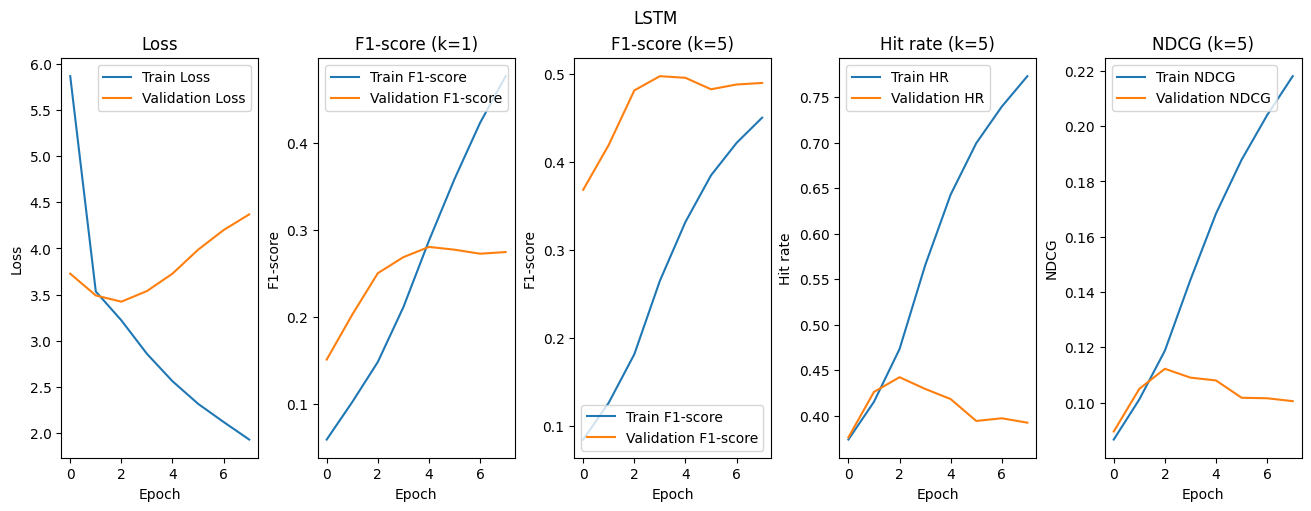

In [30]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(13, 5), constrained_layout=True)

plt.subplots_adjust(wspace=0.4)

ax1.plot(history_model_lstm.history['loss'], label='Train Loss')
ax1.plot(history_model_lstm.history['val_loss'], label='Validation Loss')
ax1.set_title('Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(history_model_lstm.history['f1_score'], label='Train F1-score')
ax2.plot(history_model_lstm.history['val_f1_score'], label='Validation F1-score')
ax2.set_title('F1-score (k=1)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('F1-score')
ax2.legend()

ax3.plot(history_model_lstm.history['f1_score_at_k'], label='Train F1-score')
ax3.plot(history_model_lstm.history['val_f1_score_at_k'], label='Validation F1-score')
ax3.set_title('F1-score (k=5)')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('F1-score')
ax3.legend()

ax4.plot(history_model_lstm.history['hit_rate_at_k'], label='Train HR')
ax4.plot(history_model_lstm.history['val_hit_rate_at_k'], label='Validation HR')
ax4.set_title('Hit rate (k=5)')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Hit rate')
ax4.legend()

ax5.plot(history_model_lstm.history['ndcg_at_k'], label='Train NDCG')
ax5.plot(history_model_lstm.history['val_ndcg_at_k'], label='Validation NDCG')
ax5.set_title('NDCG (k=5)')
ax5.set_xlabel('Epoch')
ax5.set_ylabel('NDCG')
ax5.legend()

plt.suptitle('LSTM')
plt.show()

In [31]:
model_lstm_test_loss, model_lstm_test_accuracy, model_lstm_test_f1_score_k_1, model_lstm_test_f1_score_k_5, model_lstm_test_hr, model_lstm_test_ndcg = model_lstm.evaluate(test_dataset)

print("Test loss:", round(model_lstm_test_loss, 4))
print("Test accuracy:", round(model_lstm_test_accuracy, 4))
print("Test F1@1:", round(model_lstm_test_f1_score_k_1, 4))
print("Test F1@5:", round(model_lstm_test_f1_score_k_5, 4))
print("Test HR@5:", round(model_lstm_test_hr, 4))
print("Test NDCG@5:", round(model_lstm_test_ndcg, 4))

parameters["model_lstm_test_loss"] = model_lstm_test_loss
parameters["model_lstm_test_accuracy"] = round(model_lstm_test_accuracy, 4)
parameters["model_lstm_test_f1_score_k_1"] = round(model_lstm_test_f1_score_k_1, 4)
parameters["model_lstm_test_f1_score_k_5"] = round(model_lstm_test_f1_score_k_5, 4)
parameters["model_lstm_test_hr"] = round(model_lstm_test_hr, 4)
parameters["model_lstm_test_ndcg"] = round(model_lstm_test_ndcg, 4)

54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.1694 - f1_score: 0.2505 - f1_score_at_k: 0.5012 - hit_rate_at_k: 0.4015 - loss: 4.1657 - ndcg_at_k: 0.0979
Test loss: 4.3986
Test accuracy: 0.2016
Test F1@1: 0.2866
Test F1@5: 0.5081
Test HR@5: 0.4139
Test NDCG@5: 0.106


In [32]:
parameters

{'user': 'users-12',
 'user_id': 'A9NXTC0HTPSDO',
 'number_of_sequences_and_targets_before_removal': 18439,
 'number_of_sequences_and_targets_after_removal': 18064,
 'number_of_sequences_and_targets_after_dropping_duplicates_after_encoding': 16916,
 'num_unique_product_ids_in_targets': 97,
 'num_unique_product_ids_in_sequences': 12374,
 'number_of_sequences_and_targets_train': 13528,
 'number_of_sequences_and_targets_validation': 1682,
 'number_of_sequences_and_targets_test': 1706,
 'number_of_unique_products_in_targets_train': 89,
 'number_of_unique_products_in_targets_validation': 89,
 'number_of_unique_products_in_targets_test': 97,
 'model_lstm_test_loss': 4.398611545562744,
 'model_lstm_test_accuracy': 0.2016,
 'model_lstm_test_f1_score_k_1': 0.2866,
 'model_lstm_test_f1_score_k_5': 0.5081,
 'model_lstm_test_hr': 0.4139,
 'model_lstm_test_ndcg': 0.106}

---------

## Bidirectional-LSTM

In [33]:
model_bi_lstm = Sequential()
model_bi_lstm.add(Embedding(input_dim=max_product_id, output_dim=50))
model_bi_lstm.add(Bidirectional(LSTM(32, activation='relu', return_sequences=True)))
model_bi_lstm.add(BatchNormalization())
model_bi_lstm.add(Dropout(0.2))
model_bi_lstm.add(Bidirectional(LSTM(32, activation='relu')))
model_bi_lstm.add(BatchNormalization())
model_bi_lstm.add(Dropout(0.2))
model_bi_lstm.add(Dense(16, activation='relu'))
model_bi_lstm.add(Dense(max_product_id, activation='softmax'))

model_bi_lstm.compile(
    loss='sparse_categorical_crossentropy', 
    optimizer=Adam(learning_rate=0.001), 
    metrics=['accuracy', f1_score, f1_score_at_k, hit_rate_at_k, ndcg_at_k]
)

In [34]:
history_model_bi_lstm = model_bi_lstm.fit(
    train_dataset,
    epochs=50,
    batch_size=BATCH_SIZE,
    validation_data=val_dataset,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5)]
)

Epoch 1/50
423/423 ━━━━━━━━━━━━━━━━━━━━ 27s 32ms/step - accuracy: 0.1292 - f1_score: 0.0545 - f1_score_at_k: 0.0929 - hit_rate_at_k: 0.3739 - loss: 7.9652 - ndcg_at_k: 0.0866 - val_accuracy: 0.1611 - val_f1_score: 0.1650 - val_f1_score_at_k: 0.3911 - val_hit_rate_at_k: 0.4021 - val_loss: 3.6772 - val_ndcg_at_k: 0.0960
Epoch 2/50
423/423 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.1929 - f1_score: 0.1156 - f1_score_at_k: 0.1530 - hit_rate_at_k: 0.4513 - loss: 3.3512 - ndcg_at_k: 0.1104 - val_accuracy: 0.2229 - val_f1_score: 0.2541 - val_f1_score_at_k: 0.4744 - val_hit_rate_at_k: 0.4569 - val_loss: 3.4060 - val_ndcg_at_k: 0.1162
Epoch 3/50
423/423 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.2488 - f1_score: 0.1772 - f1_score_at_k: 0.2431 - hit_rate_at_k: 0.5519 - loss: 2.9461 - ndcg_at_k: 0.1370 - val_accuracy: 0.2212 - val_f1_score: 0.2679 - val_f1_score_at_k: 0.5050 - val_hit_rate_at_k: 0.4490 - val_loss: 3.4780 - val_ndcg_at_k: 0.1146
Epoch 4/50
423/423 ━━━━━━━━━━━━━━━━━━━━ 3s 7

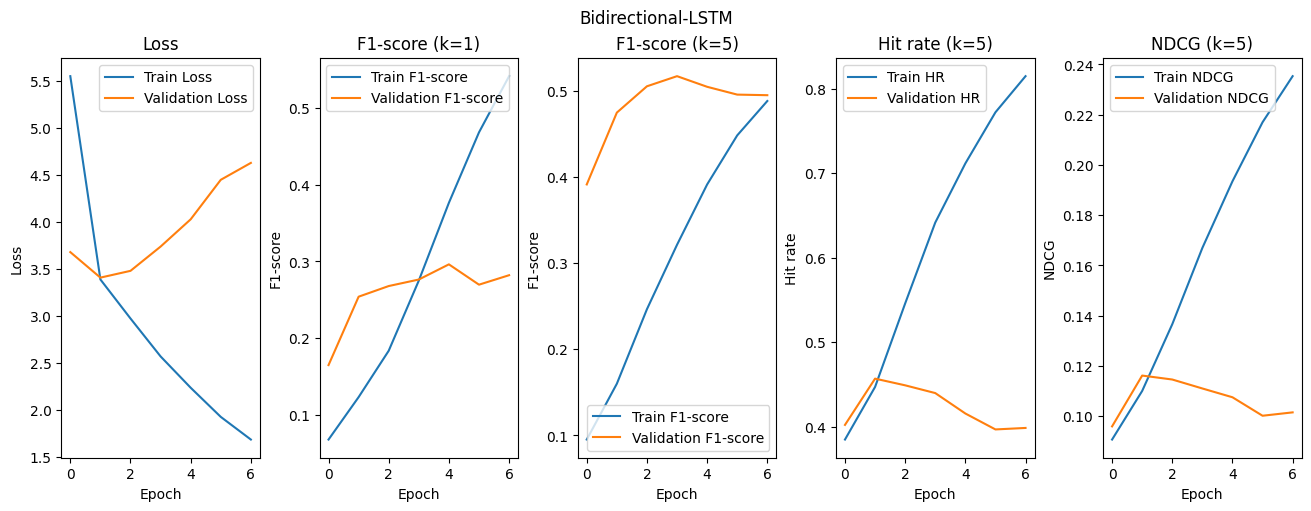

In [35]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(13, 5), constrained_layout=True)

plt.subplots_adjust(wspace=0.4)

ax1.plot(history_model_bi_lstm.history['loss'], label='Train Loss')
ax1.plot(history_model_bi_lstm.history['val_loss'], label='Validation Loss')
ax1.set_title('Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(history_model_bi_lstm.history['f1_score'], label='Train F1-score')
ax2.plot(history_model_bi_lstm.history['val_f1_score'], label='Validation F1-score')
ax2.set_title('F1-score (k=1)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('F1-score')
ax2.legend()

ax3.plot(history_model_bi_lstm.history['f1_score_at_k'], label='Train F1-score')
ax3.plot(history_model_bi_lstm.history['val_f1_score_at_k'], label='Validation F1-score')
ax3.set_title('F1-score (k=5)')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('F1-score')
ax3.legend()

ax4.plot(history_model_bi_lstm.history['hit_rate_at_k'], label='Train HR')
ax4.plot(history_model_bi_lstm.history['val_hit_rate_at_k'], label='Validation HR')
ax4.set_title('Hit rate (k=5)')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Hit rate')
ax4.legend()

ax5.plot(history_model_bi_lstm.history['ndcg_at_k'], label='Train NDCG')
ax5.plot(history_model_bi_lstm.history['val_ndcg_at_k'], label='Validation NDCG')
ax5.set_title('NDCG (k=5)')
ax5.set_xlabel('Epoch')
ax5.set_ylabel('NDCG')
ax5.legend()

plt.suptitle('Bidirectional-LSTM')
plt.show()

In [36]:
model_bi_lstm_test_loss, model_bi_lstm_test_accuracy, model_bi_lstm_test_f1_score_k_1, model_bi_lstm_test_f1_score_k_5, model_bi_lstm_test_hr, model_bi_lstm_test_ndcg = model_bi_lstm.evaluate(test_dataset)

print("Test loss:", round(model_bi_lstm_test_loss, 4))
print("Test accuracy:", round(model_bi_lstm_test_accuracy, 4))
print("Test F1@1:", round(model_bi_lstm_test_f1_score_k_1, 4))
print("Test F1@5:", round(model_bi_lstm_test_f1_score_k_5, 4))
print("Test HR@5:", round(model_bi_lstm_test_hr, 4))
print("Test NDCG@5:", round(model_bi_lstm_test_ndcg, 4))

parameters["model_bi_lstm_test_loss"] = model_bi_lstm_test_loss
parameters["model_bi_lstm_test_accuracy"] = round(model_bi_lstm_test_accuracy, 4)
parameters["model_bi_lstm_test_f1_score_k_1"] = round(model_bi_lstm_test_f1_score_k_1, 4)
parameters["model_bi_lstm_test_f1_score_k_5"] = round(model_bi_lstm_test_f1_score_k_5, 4)
parameters["model_bi_lstm_test_hr"] = round(model_bi_lstm_test_hr, 4)
parameters["model_bi_lstm_test_ndcg"] = round(model_bi_lstm_test_ndcg, 4)

54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.1564 - f1_score: 0.2403 - f1_score_at_k: 0.5177 - hit_rate_at_k: 0.4209 - loss: 4.4409 - ndcg_at_k: 0.0985   
Test loss: 4.6231
Test accuracy: 0.2034
Test F1@1: 0.2969
Test F1@5: 0.524
Test HR@5: 0.4231
Test NDCG@5: 0.1074


In [37]:
parameters

{'user': 'users-12',
 'user_id': 'A9NXTC0HTPSDO',
 'number_of_sequences_and_targets_before_removal': 18439,
 'number_of_sequences_and_targets_after_removal': 18064,
 'number_of_sequences_and_targets_after_dropping_duplicates_after_encoding': 16916,
 'num_unique_product_ids_in_targets': 97,
 'num_unique_product_ids_in_sequences': 12374,
 'number_of_sequences_and_targets_train': 13528,
 'number_of_sequences_and_targets_validation': 1682,
 'number_of_sequences_and_targets_test': 1706,
 'number_of_unique_products_in_targets_train': 89,
 'number_of_unique_products_in_targets_validation': 89,
 'number_of_unique_products_in_targets_test': 97,
 'model_lstm_test_loss': 4.398611545562744,
 'model_lstm_test_accuracy': 0.2016,
 'model_lstm_test_f1_score_k_1': 0.2866,
 'model_lstm_test_f1_score_k_5': 0.5081,
 'model_lstm_test_hr': 0.4139,
 'model_lstm_test_ndcg': 0.106,
 'model_bi_lstm_test_loss': 4.623146057128906,
 'model_bi_lstm_test_accuracy': 0.2034,
 'model_bi_lstm_test_f1_score_k_1': 0.2969,

-------

# GRU

In [38]:
model_gru = Sequential()
model_gru.add(Embedding(input_dim=max_product_id, output_dim=50))
model_gru.add(GRU(32, activation='relu', return_sequences=True))
model_gru.add(BatchNormalization())
model_gru.add(Dropout(0.2))
model_gru.add(GRU(32, activation='relu'))
model_gru.add(BatchNormalization())
model_gru.add(Dropout(0.2))
model_gru.add(Dense(16, activation='relu'))
model_gru.add(Dense(max_product_id, activation='softmax'))

model_gru.compile(
    loss='sparse_categorical_crossentropy', 
    optimizer=Adam(learning_rate=0.001), 
    metrics=['accuracy', f1_score, f1_score_at_k, hit_rate_at_k, ndcg_at_k]
)

In [39]:
history_model_gru = model_gru.fit(
    train_dataset,
    epochs=50,
    batch_size=BATCH_SIZE,
    validation_data=val_dataset,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5)]
)

Epoch 1/50
423/423 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.1296 - f1_score: 0.0608 - f1_score_at_k: 0.0940 - hit_rate_at_k: 0.3701 - loss: 8.3274 - ndcg_at_k: 0.0858 - val_accuracy: 0.1724 - val_f1_score: 0.1787 - val_f1_score_at_k: 0.4006 - val_hit_rate_at_k: 0.4104 - val_loss: 3.6603 - val_ndcg_at_k: 0.0984
Epoch 2/50
423/423 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.1842 - f1_score: 0.0975 - f1_score_at_k: 0.1327 - hit_rate_at_k: 0.4285 - loss: 3.4840 - ndcg_at_k: 0.1052 - val_accuracy: 0.1831 - val_f1_score: 0.2002 - val_f1_score_at_k: 0.4314 - val_hit_rate_at_k: 0.4264 - val_loss: 3.5054 - val_ndcg_at_k: 0.1046
Epoch 3/50
423/423 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.1949 - f1_score: 0.1119 - f1_score_at_k: 0.1577 - hit_rate_at_k: 0.4546 - loss: 3.2847 - ndcg_at_k: 0.1117 - val_accuracy: 0.2063 - val_f1_score: 0.2425 - val_f1_score_at_k: 0.4677 - val_hit_rate_at_k: 0.4349 - val_loss: 3.4525 - val_ndcg_at_k: 0.1095
Epoch 4/50
423/423 ━━━━━━━━━━━━━━━━━━━━ 3s 6

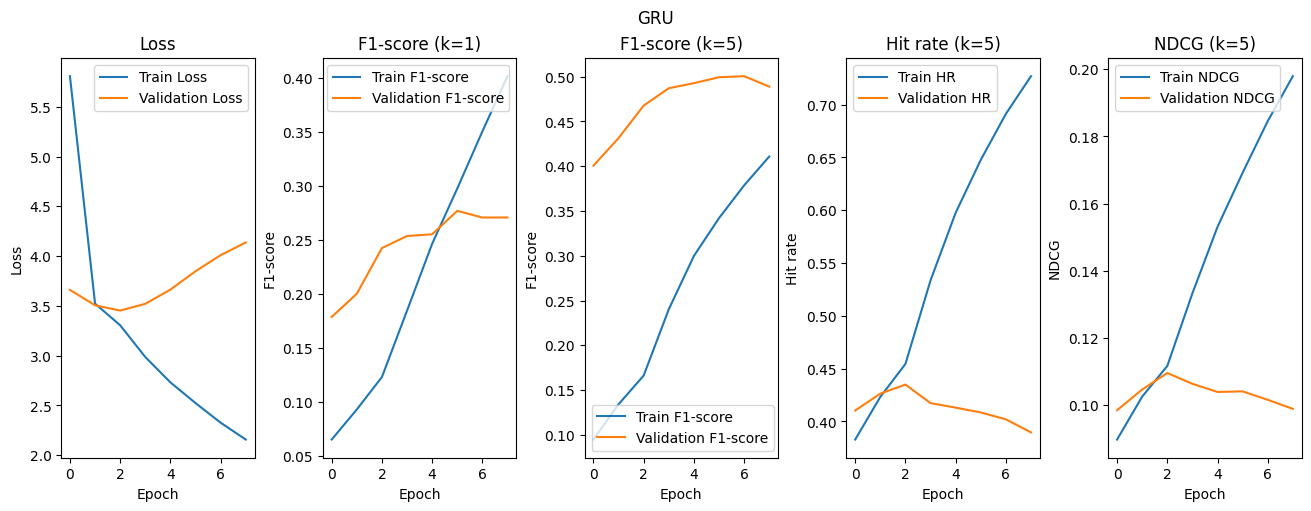

In [40]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(13, 5), constrained_layout=True)

plt.subplots_adjust(wspace=0.4)

ax1.plot(history_model_gru.history['loss'], label='Train Loss')
ax1.plot(history_model_gru.history['val_loss'], label='Validation Loss')
ax1.set_title('Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(history_model_gru.history['f1_score'], label='Train F1-score')
ax2.plot(history_model_gru.history['val_f1_score'], label='Validation F1-score')
ax2.set_title('F1-score (k=1)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('F1-score')
ax2.legend()

ax3.plot(history_model_gru.history['f1_score_at_k'], label='Train F1-score')
ax3.plot(history_model_gru.history['val_f1_score_at_k'], label='Validation F1-score')
ax3.set_title('F1-score (k=5)')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('F1-score')
ax3.legend()

ax4.plot(history_model_gru.history['hit_rate_at_k'], label='Train HR')
ax4.plot(history_model_gru.history['val_hit_rate_at_k'], label='Validation HR')
ax4.set_title('Hit rate (k=5)')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Hit rate')
ax4.legend()

ax5.plot(history_model_gru.history['ndcg_at_k'], label='Train NDCG')
ax5.plot(history_model_gru.history['val_ndcg_at_k'], label='Validation NDCG')
ax5.set_title('NDCG (k=5)')
ax5.set_xlabel('Epoch')
ax5.set_ylabel('NDCG')
ax5.legend()

plt.suptitle('GRU')
plt.show()

In [41]:
model_gru_test_loss, model_gru_test_accuracy, model_gru_test_f1_score_k_1, model_gru_test_f1_score_k_5, model_gru_test_hr, model_gru_test_ndcg = model_gru.evaluate(test_dataset)

print("Test loss:", round(model_gru_test_loss, 4))
print("Test accuracy:", round(model_gru_test_accuracy, 4))
print("Test F1@1:", round(model_gru_test_f1_score_k_1, 4))
print("Test F1@5:", round(model_gru_test_f1_score_k_5, 4))
print("Test HR@5:", round(model_gru_test_hr, 4))
print("Test NDCG@5:", round(model_gru_test_ndcg, 4))

parameters["model_gru_test_loss"] = model_gru_test_loss
parameters["model_gru_test_accuracy"] = round(model_gru_test_accuracy, 4)
parameters["model_gru_test_f1_score_k_1"] = round(model_gru_test_f1_score_k_1, 4)
parameters["model_gru_test_f1_score_k_5"] = round(model_gru_test_f1_score_k_5, 4)
parameters["model_gru_test_hr"] = round(model_gru_test_hr, 4)
parameters["model_gru_test_ndcg"] = round(model_gru_test_ndcg, 4)

54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.1346 - f1_score: 0.2032 - f1_score_at_k: 0.4712 - hit_rate_at_k: 0.3737 - loss: 4.1505 - ndcg_at_k: 0.0865  
Test loss: 4.2962
Test accuracy: 0.1882
Test F1@1: 0.2711
Test F1@5: 0.4894
Test HR@5: 0.392
Test NDCG@5: 0.1


In [42]:
parameters

{'user': 'users-12',
 'user_id': 'A9NXTC0HTPSDO',
 'number_of_sequences_and_targets_before_removal': 18439,
 'number_of_sequences_and_targets_after_removal': 18064,
 'number_of_sequences_and_targets_after_dropping_duplicates_after_encoding': 16916,
 'num_unique_product_ids_in_targets': 97,
 'num_unique_product_ids_in_sequences': 12374,
 'number_of_sequences_and_targets_train': 13528,
 'number_of_sequences_and_targets_validation': 1682,
 'number_of_sequences_and_targets_test': 1706,
 'number_of_unique_products_in_targets_train': 89,
 'number_of_unique_products_in_targets_validation': 89,
 'number_of_unique_products_in_targets_test': 97,
 'model_lstm_test_loss': 4.398611545562744,
 'model_lstm_test_accuracy': 0.2016,
 'model_lstm_test_f1_score_k_1': 0.2866,
 'model_lstm_test_f1_score_k_5': 0.5081,
 'model_lstm_test_hr': 0.4139,
 'model_lstm_test_ndcg': 0.106,
 'model_bi_lstm_test_loss': 4.623146057128906,
 'model_bi_lstm_test_accuracy': 0.2034,
 'model_bi_lstm_test_f1_score_k_1': 0.2969,

-------

# Autoencoder

In [43]:
nn = [64, 32, 16, 32, 64]

model_autoencoder = Sequential()
model_autoencoder.add(Embedding(input_dim=max_product_id, output_dim=50))
model_autoencoder.add(Flatten())
model_autoencoder.add(Dense(units=nn[0], activation='relu'))
model_autoencoder.add(BatchNormalization())
model_autoencoder.add(Dropout(0.2))
for n in nn[1:]:
    model_autoencoder.add(Dense(units=n, activation='relu'))
    model_autoencoder.add(BatchNormalization())
    model_autoencoder.add(Dropout(0.2))
model_autoencoder.add(Dense(max_product_id, activation='softmax'))

model_autoencoder.compile(
    loss='sparse_categorical_crossentropy', 
    optimizer=Adam(learning_rate=0.001), 
    metrics=['accuracy', f1_score, f1_score_at_k, hit_rate_at_k, ndcg_at_k]
)

In [44]:
history_model_autoencoder = model_autoencoder.fit(
    train_dataset,
    epochs=50,
    batch_size=BATCH_SIZE,
    validation_data=val_dataset,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5)]
)

Epoch 1/50
423/423 ━━━━━━━━━━━━━━━━━━━━ 28s 35ms/step - accuracy: 0.0688 - f1_score: 0.0534 - f1_score_at_k: 0.0924 - hit_rate_at_k: 0.1911 - loss: 10.3923 - ndcg_at_k: 0.0444 - val_accuracy: 0.1683 - val_f1_score: 0.1743 - val_f1_score_at_k: 0.4036 - val_hit_rate_at_k: 0.4045 - val_loss: 3.6392 - val_ndcg_at_k: 0.0966
Epoch 2/50
423/423 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.1774 - f1_score: 0.1049 - f1_score_at_k: 0.1439 - hit_rate_at_k: 0.4069 - loss: 3.6423 - ndcg_at_k: 0.1001 - val_accuracy: 0.1914 - val_f1_score: 0.2008 - val_f1_score_at_k: 0.4269 - val_hit_rate_at_k: 0.4318 - val_loss: 3.4833 - val_ndcg_at_k: 0.1061
Epoch 3/50
423/423 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.1848 - f1_score: 0.1096 - f1_score_at_k: 0.1476 - hit_rate_at_k: 0.4333 - loss: 3.4721 - ndcg_at_k: 0.1058 - val_accuracy: 0.1956 - val_f1_score: 0.2130 - val_f1_score_at_k: 0.4375 - val_hit_rate_at_k: 0.4363 - val_loss: 3.4597 - val_ndcg_at_k: 0.1077
Epoch 4/50
423/423 ━━━━━━━━━━━━━━━━━━━━ 5s 

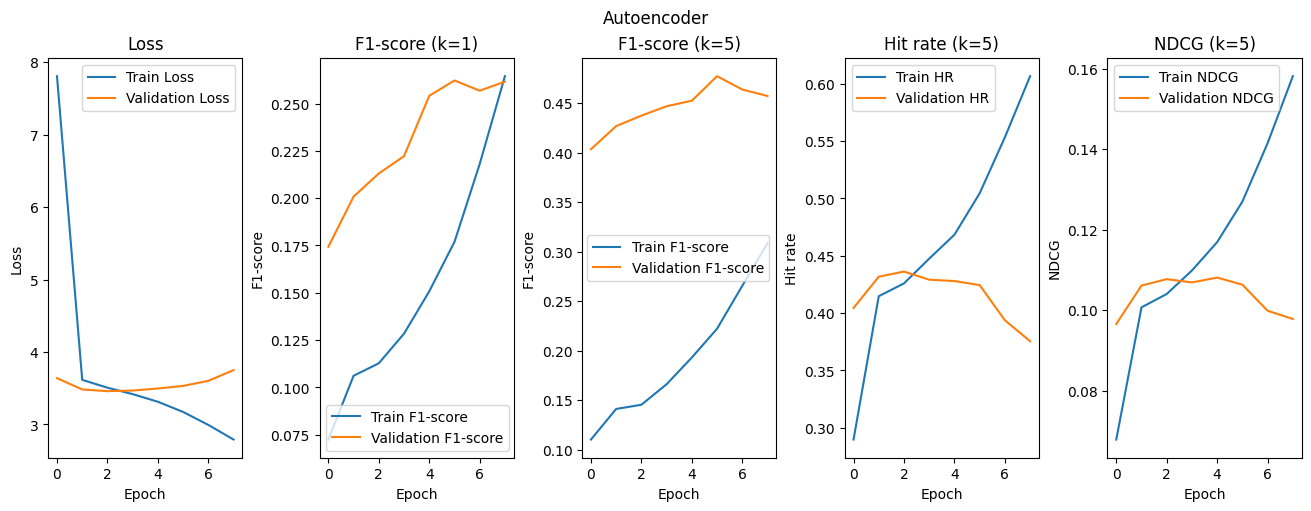

In [45]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(13, 5), constrained_layout=True)

plt.subplots_adjust(wspace=0.4)

ax1.plot(history_model_autoencoder.history['loss'], label='Train Loss')
ax1.plot(history_model_autoencoder.history['val_loss'], label='Validation Loss')
ax1.set_title('Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(history_model_autoencoder.history['f1_score'], label='Train F1-score')
ax2.plot(history_model_autoencoder.history['val_f1_score'], label='Validation F1-score')
ax2.set_title('F1-score (k=1)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('F1-score')
ax2.legend()

ax3.plot(history_model_autoencoder.history['f1_score_at_k'], label='Train F1-score')
ax3.plot(history_model_autoencoder.history['val_f1_score_at_k'], label='Validation F1-score')
ax3.set_title('F1-score (k=5)')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('F1-score')
ax3.legend()

ax4.plot(history_model_autoencoder.history['hit_rate_at_k'], label='Train HR')
ax4.plot(history_model_autoencoder.history['val_hit_rate_at_k'], label='Validation HR')
ax4.set_title('Hit rate (k=5)')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Hit rate')
ax4.legend()

ax5.plot(history_model_autoencoder.history['ndcg_at_k'], label='Train NDCG')
ax5.plot(history_model_autoencoder.history['val_ndcg_at_k'], label='Validation NDCG')
ax5.set_title('NDCG (k=5)')
ax5.set_xlabel('Epoch')
ax5.set_ylabel('NDCG')
ax5.legend()

plt.suptitle('Autoencoder')
plt.show()

In [46]:
model_autoencoder_test_loss, model_autoencoder_test_accuracy, model_autoencoder_test_f1_score_k_1, model_autoencoder_test_f1_score_k_5, model_autoencoder_test_hr, model_autoencoder_test_ndcg = model_autoencoder.evaluate(test_dataset)

print("Test loss:", round(model_autoencoder_test_loss, 4))
print("Test accuracy:", round(model_autoencoder_test_accuracy, 4))
print("Test F1@1:", round(model_autoencoder_test_f1_score_k_1, 4))
print("Test F1@5:", round(model_autoencoder_test_f1_score_k_5, 4))
print("Test HR@5:", round(model_autoencoder_test_hr, 4))
print("Test NDCG@5:", round(model_autoencoder_test_ndcg, 4))

parameters["model_autoencoder_test_loss"] = model_autoencoder_test_loss
parameters["model_autoencoder_test_accuracy"] = round(model_autoencoder_test_accuracy, 4)
parameters["model_autoencoder_test_f1_score_k_1"] = round(model_autoencoder_test_f1_score_k_1, 4)
parameters["model_autoencoder_test_f1_score_k_5"] = round(model_autoencoder_test_f1_score_k_5, 4)
parameters["model_autoencoder_test_hr"] = round(model_autoencoder_test_hr, 4)
parameters["model_autoencoder_test_ndcg"] = round(model_autoencoder_test_ndcg, 4)

54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.1769 - f1_score: 0.2528 - f1_score_at_k: 0.4906 - hit_rate_at_k: 0.4091 - loss: 3.6650 - ndcg_at_k: 0.1009
Test loss: 3.7921
Test accuracy: 0.1999
Test F1@1: 0.2728
Test F1@5: 0.4878
Test HR@5: 0.4087
Test NDCG@5: 0.1056


In [47]:
parameters

{'user': 'users-12',
 'user_id': 'A9NXTC0HTPSDO',
 'number_of_sequences_and_targets_before_removal': 18439,
 'number_of_sequences_and_targets_after_removal': 18064,
 'number_of_sequences_and_targets_after_dropping_duplicates_after_encoding': 16916,
 'num_unique_product_ids_in_targets': 97,
 'num_unique_product_ids_in_sequences': 12374,
 'number_of_sequences_and_targets_train': 13528,
 'number_of_sequences_and_targets_validation': 1682,
 'number_of_sequences_and_targets_test': 1706,
 'number_of_unique_products_in_targets_train': 89,
 'number_of_unique_products_in_targets_validation': 89,
 'number_of_unique_products_in_targets_test': 97,
 'model_lstm_test_loss': 4.398611545562744,
 'model_lstm_test_accuracy': 0.2016,
 'model_lstm_test_f1_score_k_1': 0.2866,
 'model_lstm_test_f1_score_k_5': 0.5081,
 'model_lstm_test_hr': 0.4139,
 'model_lstm_test_ndcg': 0.106,
 'model_bi_lstm_test_loss': 4.623146057128906,
 'model_bi_lstm_test_accuracy': 0.2034,
 'model_bi_lstm_test_f1_score_k_1': 0.2969,

-----

#### Predicting target for the last sequence of the specific user

In [48]:
predicted_user = {
    'userID': last_user_sequence[0],
    'sequence': [encoding[last_user_sequence[2]], encoding[last_user_sequence[3]]],
    'target': encoding[last_user_sequence[1]]
}

predicted_user

{'userID': 'A9NXTC0HTPSDO', 'sequence': [120588, 90069], 'target': 139247}

In [49]:
input_data = np.array([predicted_user['sequence']])
predictions = model_lstm.predict(input_data)

k_values = [5, 10, 20, 50, 100, 200, 300, 400, 500]

for k in k_values:
    hit_rate = hit_rate_at_k(np.array([predicted_user['target']]), predictions, k=k).numpy()
    print(f"HT@{k}: {hit_rate}")
    
    ndcg = ndcg_at_k(np.array([predicted_user['target']]), predictions, k=k).numpy()
    print(f"NDCG@{k}: {ndcg}")
    
    print("-------------")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
HT@5: 0.0
NDCG@5: 0.0
-------------
HT@10: 1.0
NDCG@10: 0.07336392253637314
-------------
HT@20: 1.0
NDCG@20: 0.04734668508172035
-------------
HT@50: 1.0
NDCG@50: 0.025844337418675423
-------------
HT@100: 1.0
NDCG@100: 0.015919506549835205
-------------
HT@200: 1.0
NDCG@200: 0.009573574177920818
-------------
HT@300: 1.0
NDCG@300: 0.007035486400127411
-------------
HT@400: 1.0
NDCG@400: 0.005629485007375479
-------------
HT@500: 1.0
NDCG@500: 0.004724326077848673
-------------
